In [2]:
import astra
import dicom2nifti
import dicom2nifti.compressed_dicom as compressed_dicom
import copy
import importlib
import itertools
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as regs
import numpy as np
import os
import shutil
import pandas as pd
import pylab
import random
import shutil
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [129]:
def estimate_mean(mu, sigma, x,y,z, alpha=1):
    neighbors = list(itertools.product([x-1,x,x+1], [y-1,y,y+1], [z-1,z,z+1]))
    #neighbors = [(x,y,z-1), (x,y,z+1), (x,y-1,z), (x,y+1,z), (x-1,y,z), (x+1,y,z)]
    N = len(neighbors)
    mu_i = mu[x,y,z]
    mu_j = [mu[n] for n in neighbors]
    
    var_i = sigma[x,y,z]**2
    var_j = [sigma[n]**2 for n in neighbors]
    
    return (mu_i/var_i + alpha/N*sum([mu_j[j]/var_j[j]**2 for j in range(N)])) / \
            (1/var_i + alpha/N*sum([1/var_j[j]**2 for j in range(N)]))

In [3]:
img_dir = r"D:\CBCT\AARON"
dcm_path = img_dir+"\\15814.dcm"

In [4]:
dicom_input = compressed_dicom.read_file(dcm_path,
                                       defer_size=100,
                                       stop_before_pixels=False,
                                       force=False)

In [5]:
cine_rate = float(dicom_input[('0018', '0040')].value)
kvp = float(dicom_input[('0018', '0060')].value)
d_detector = int(dicom_input[('0018', '1110')].value)
d_patient = int(dicom_input[('0018', '1111')].value)
t_exposure = int(dicom_input[('0018', '1150')].value)
current = int(dicom_input[('0018', '1151')].value)
exposure = int(dicom_input[('0018', '1152')].value)
pixel_spacing = dicom_input[('0018', '1164')].value
angle1 = float(dicom_input[('0018', '1510')].value)
angle2 = float(dicom_input[('0018', '1511')].value)
angle1_increment = dicom_input[('0018', '1520')].value
angle2_increment = dicom_input[('0018', '1521')].value
shutter_edges = [int(dicom_input[('0018', str(x))].value) for x in [1602, 1604, 1606, 1608]]

In [ ]:
recon_ref_img,_ = hf.dcm_load(img_dir+"\\15810.dcm")
recon_ref_img = np.transpose(recon_ref_img, (1,2,0))[::-1,:,:]

In [7]:
proj_imgs,_ = hf.dcm_load(img_dir+"\\15814.dcm")
proj_imgs = np.transpose(proj_imgs, (1,2,0))
proj_imgs_unscaled = copy.deepcopy(proj_imgs)
#proj_imgs = (proj_imgs - np.amin(proj_imgs)) / (np.amax(proj_imgs) - np.amin(proj_imgs))

In [124]:
proj_imgs = copy.deepcopy(proj_imgs_unscaled)

In [125]:
proj_imgs = proj_imgs[:, :, 50:-50]
rows, frames, cols = proj_imgs.shape

In [ ]:
pylab.imshow(proj_data[:,100,:], cmap='gray')

In [126]:
rows, frames, cols = proj_imgs.shape
num_samples = 50
projs_per_sample = frames*3//4#20
total_frames = frames
vol_dims = [192, 192, 149]
recons = np.empty([num_samples, *vol_dims[::-1]])

In [127]:
for sample_num in range(num_samples):
    proj_indices = random.sample(range(total_frames), projs_per_sample)

    #spacing=3
    proj_data = proj_imgs[:, proj_indices, :]
    rows, frames, cols = proj_data.shape
    #proj_data = proj_data * -1 + np.amax(proj_data)

    frames = proj_data.shape[1]
    off = 0
    vol_geom = astra.create_vol_geom(vol_dims) #rows, colums, slices (y, x, z) 384, 384, 297

    angles = np.array([(angle1 + theta)/180*np.pi for theta in np.array(angle1_increment)[proj_indices]])
    #angles2 = [angle2 + theta for theta in angle2_increment[:frames]]
    #angles = np.stack([angles1, angles2])
    proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0]), float(pixel_spacing[1]),
                                       rows, cols, angles, d_patient/1, (d_detector-d_patient)/1)

    # Create a data object for the reconstruction
    rec_id = astra.data3d.create('-vol', vol_geom)
    proj_id = astra.data3d.create('-proj3d', proj_geom, proj_data) #Coordinate order: row (v), angle, column (u)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = proj_id
    cfg['option'] = {}
    #cfg['option']['DetectorSuperSampling'] = 3 # Set up multiple rays per detector element
    #cfg['option']['PixelSuperSampling'] = 3 # Set up multiple rays per detector element

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 1)

    # Get the result
    recons[sample_num] = astra.data3d.get(rec_id)# * -1

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(proj_id)

In [128]:
mu = np.mean(recons, axis=0)
sigma = np.std(recons, axis=0)
recon_final = np.empty(recons.shape[1:])

In [122]:
for x,y,z in itertools.product(range(1,recons.shape[1]-1), range(1,recons.shape[2]-1), range(1,recons.shape[3]-1)):
    recon_final[x,y,z] = estimate_mean(mu, sigma, x,y,z, alpha=1)

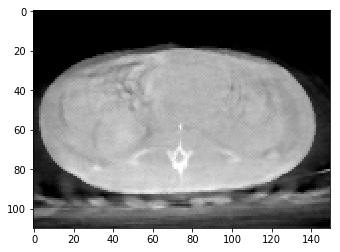

In [121]:
r = copy.deepcopy(recon_final)
pylab.imshow(r[40,10:120,20:170]*-1, cmap='gray', vmin=-.002, vmax=0.002)

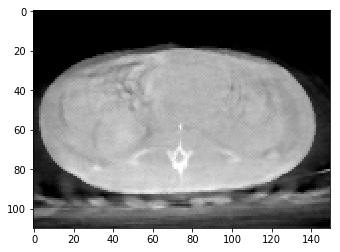

In [123]:
pylab.imshow(recon_final[40,10:120,20:170]*-1, cmap='gray', vmin=-.002, vmax=0.002)

In [58]:
print(np.amin(rec[80,10:120,20:170]), np.amax(rec[80,10:120,20:170]))

-0.003069744212552905 0.023993849754333496


pylab.imshow(np.transpose(rec[:,:,::-1][50,20:170,10:120], (1,0)), vmin=0.0005)

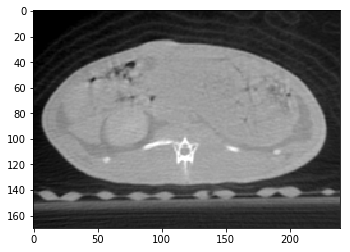

In [100]:
pylab.imshow(recon_ref_img[100,320:150:-1,50:290], cmap='gray', vmax=30000)
#pylab.imshow(recon_ref_img[70,:,:], cmap='gray')

In [78]:
incline_angles = np.array([(angle2 + theta)/180*np.pi for theta in angle2_increment[:frames]])

In [83]:
from math import sin, cos

angles = np.array([(angle1 + theta)/180*np.pi for theta in angle1_increment[off:off+frames]])
proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0]), float(pixel_spacing[1]),
                                   rows, cols, angles, d_patient/1, (d_detector-d_patient)/1)
vectors = np.zeros((len(proj_geom['ProjectionAngles']), 12))
for i in range(len(proj_geom['ProjectionAngles'])):
    # source
    vectors[i,0] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource'] * cos(incline_angles[i])
    vectors[i,1] = -cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource'] * cos(incline_angles[i])
    vectors[i,2] = proj_geom['DistanceOriginSource'] * sin(incline_angles[i]) #*-1?

    # center of detector
    vectors[i,3] = -sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector'] * cos(incline_angles[i])
    vectors[i,4] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector'] * cos(incline_angles[i])
    vectors[i,5] = -proj_geom['DistanceOriginDetector'] * sin(incline_angles[i]) #*-1?

    # vector from detector pixel (0,0) to (0,1)
    vectors[i,6] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX'] * cos(incline_angles[i])
    vectors[i,7] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX'] * cos(incline_angles[i])
    vectors[i,8] = proj_geom['DetectorSpacingX'] * sin(incline_angles[i]) #*-1?

    # vector from detector pixel (0,0) to (1,0)
    vectors[i,9] = sin(incline_angles[i]) * sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingY'] #*-1?
    vectors[i,10] = sin(incline_angles[i]) * cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingY'] #*-1?
    vectors[i,11] = proj_geom['DetectorSpacingY'] * cos(incline_angles[i])

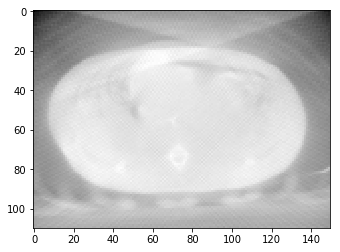

In [84]:
proj_data = proj_imgs
frames = proj_data.shape[1]
off = 0
vol_geom = astra.create_vol_geom((192, 192, 149)) #rows, colums, slices (y, x, z) 384, 384, 297
proj_geom = astra.create_proj_geom('cone_vec', rows, cols, vectors)

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)
proj_id = astra.data3d.create('-proj3d', proj_geom, proj_data[:,off:off+frames,:]) #Coordinate order: row (v), angle, column (u)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 50)

# Get the result
rec = astra.data3d.get(rec_id) * -1
pylab.figure(2)
pylab.imshow(rec[50,10:120,20:170])#, vmin=.0010, vmax=0.0035)
pylab.show()

# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)